# Checks how the model is doing so far

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import lightgbm as lgb
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
DIRECTORY = '../data/'
train = pd.read_csv(DIRECTORY + 'train.csv', parse_dates=['date']).drop(columns='id')

In [3]:
FEATURES = '../features/'

product = pd.read_csv(FEATURES + './product.csv', index_col=0).squeeze()
store = pd.read_csv(FEATURES + './store.csv', index_col=0).squeeze()
country = pd.read_csv(FEATURES + './country.csv', index_col=0).squeeze()
day_of_week = pd.read_csv(FEATURES + './day_of_week.csv', index_col=0).squeeze()

combos = [(product, 'product'), (store, 'store'), (country, 'country'), (day_of_week, 'day_of_week')]

day_of_year = {}
for product in train['product'].unique():
    day_of_year[product] = pd.read_csv(FEATURES + product + '_day_of_year.csv', index_col=0).squeeze()

In [6]:
# Apply to train

# Initializations
def prep_dataset(df: pd.DataFrame):
    df['day_of_week'] = df['date'].dt.day_of_week
    df['day_of_year'] = df['date'].dt.day_of_year
    df['prediction'] = 1

    for mapping, colname in combos:
        df['prediction'] = df['prediction'] * df[colname].map(mapping)

    for product in day_of_year:
        df.loc[df['product'] == product, 'prediction'] = df.loc[df['product'] == product]['prediction'] * \
                                                    df.loc[df['product'] == product]['day_of_year'].map(day_of_year[product])
        
    df['prediction'] = np.mean(df['num_sold'] / df['prediction']) * df['prediction']
    return df

# Sanity check groupby (everything is in the right range)
train = prep_dataset(train)
train.groupby(['product', 'store', 'country'])[['prediction', 'num_sold']].mean()

prediction     num_sold
product            store             country                            
Holographic Goose  Discount Stickers Canada      101.967138          NaN
                                     Finland     100.173516    98.001564
                                     Italy        72.598491    70.846304
                                     Kenya         2.464691          NaN
                                     Norway      190.441631   186.725851
...                                                     ...          ...
Kerneler Dark Mode Stickers for Less Finland     748.936336   752.648025
                                     Italy       542.774680   544.719984
                                     Kenya        18.426995    18.412984
                                     Norway     1423.816028  1432.892452
                                     Singapore   863.832216   867.225655

[90 rows x 2 columns]

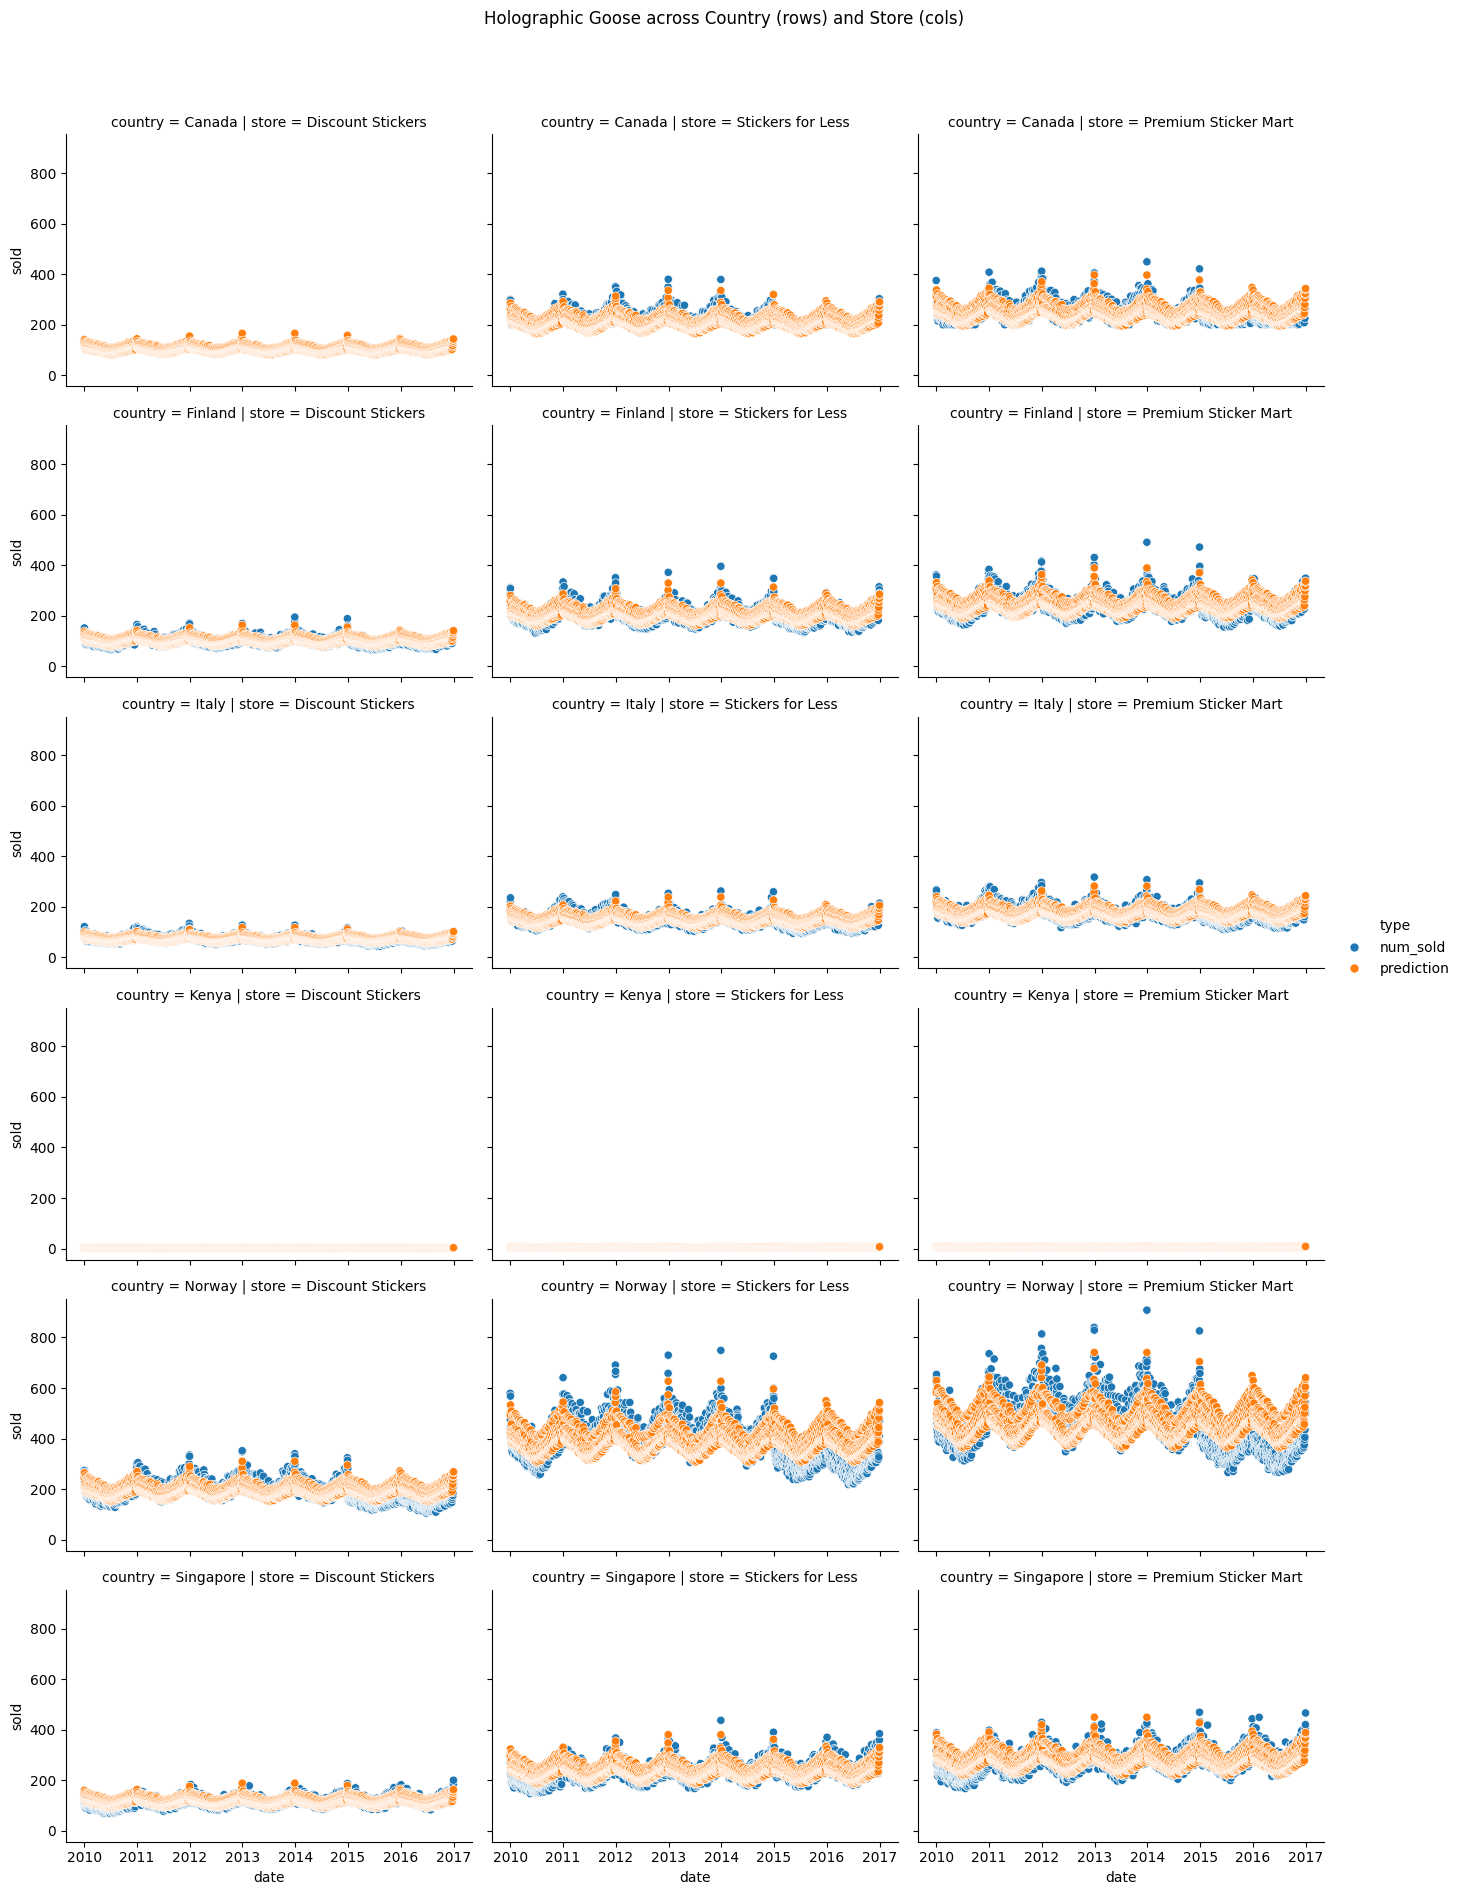

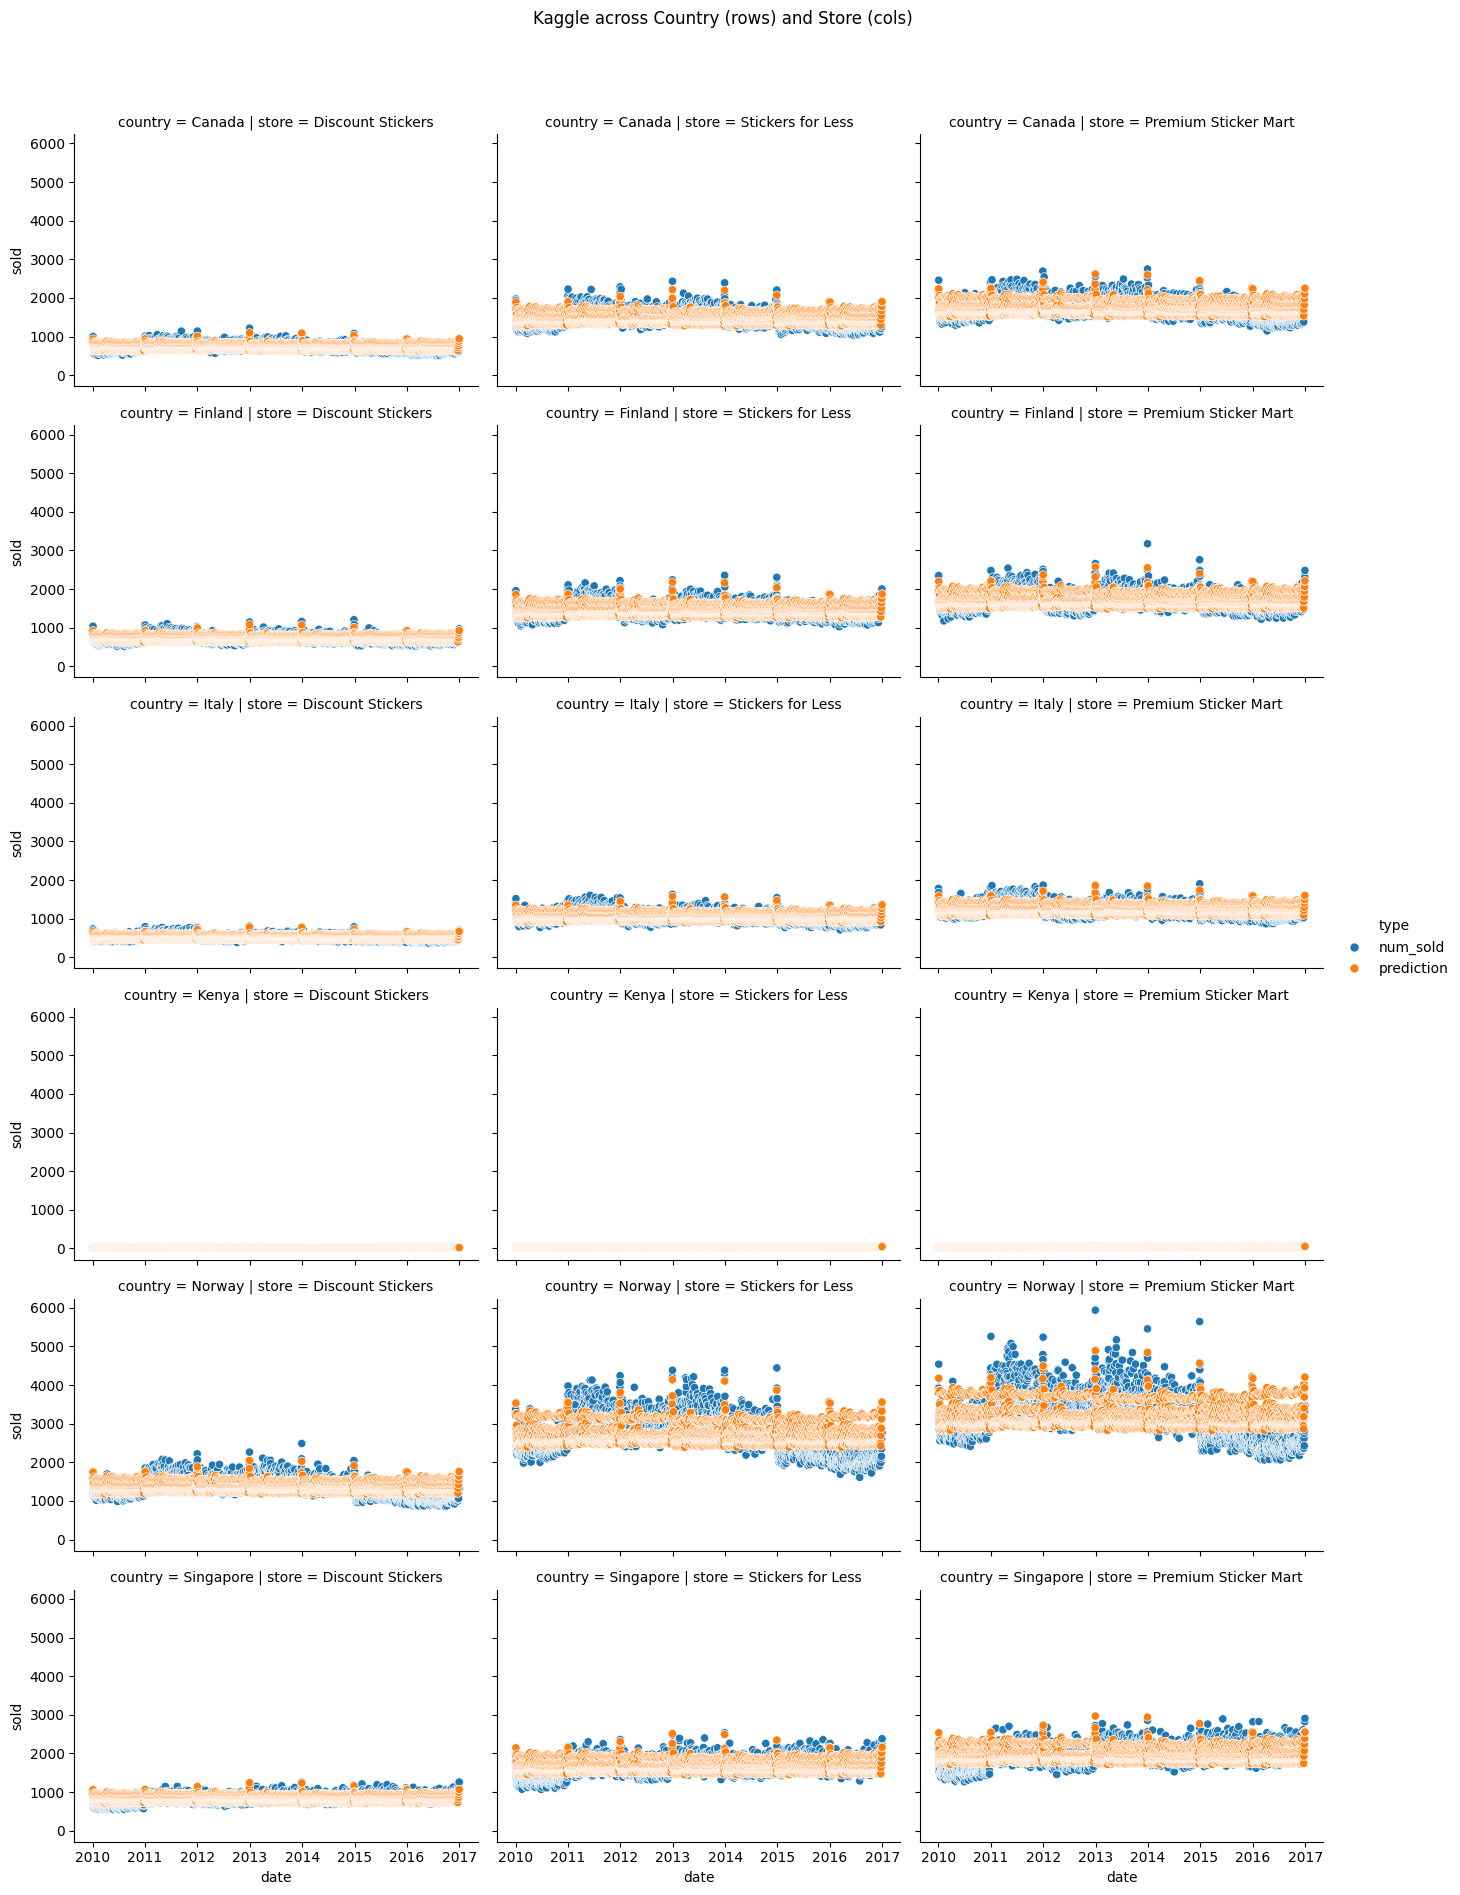

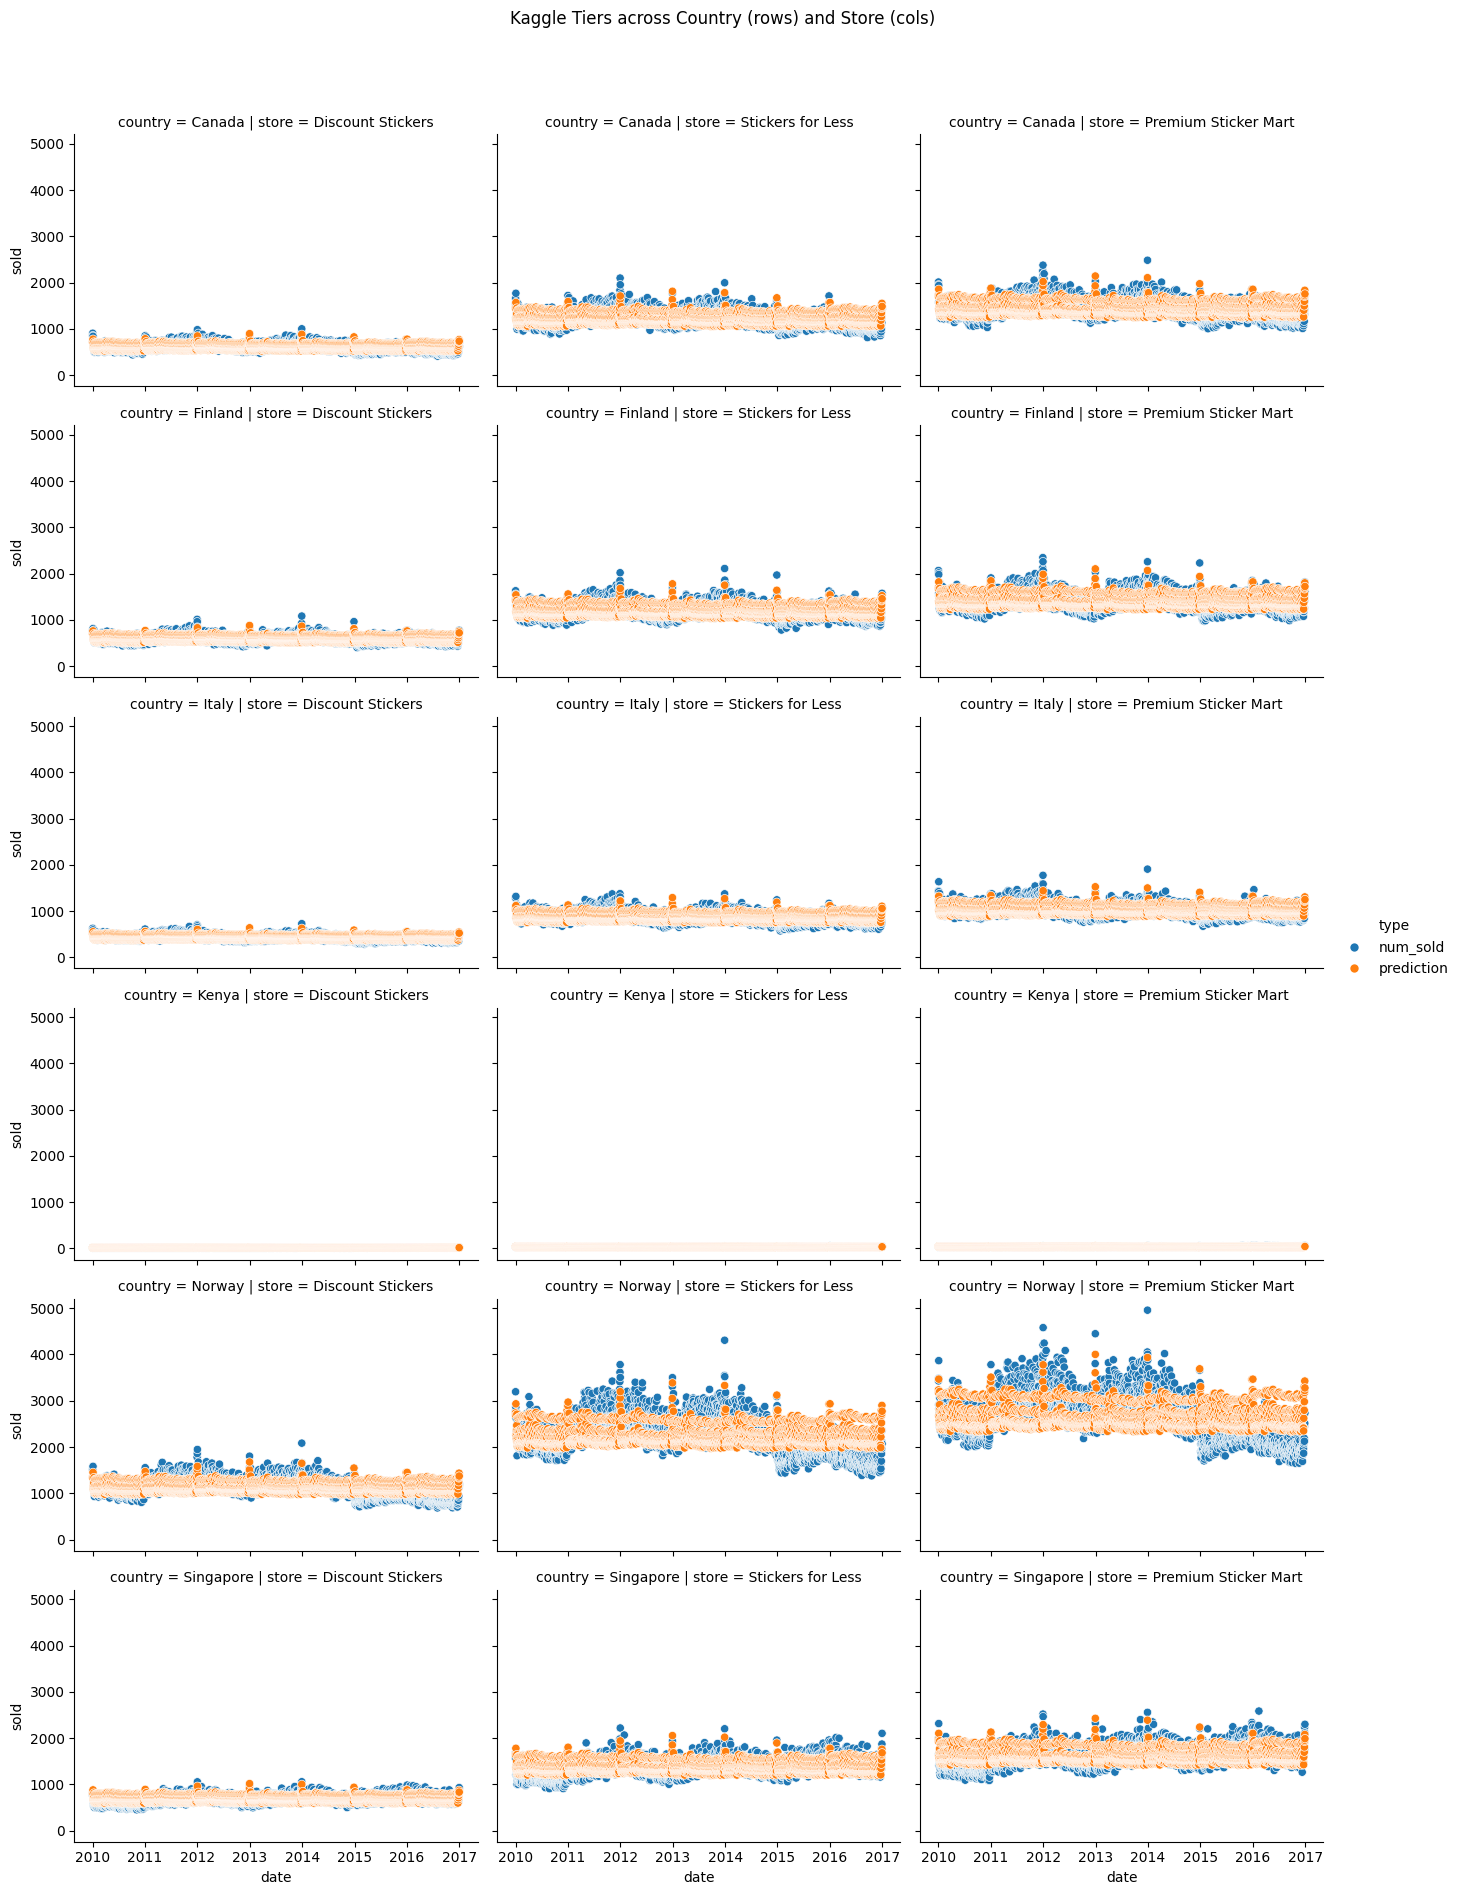

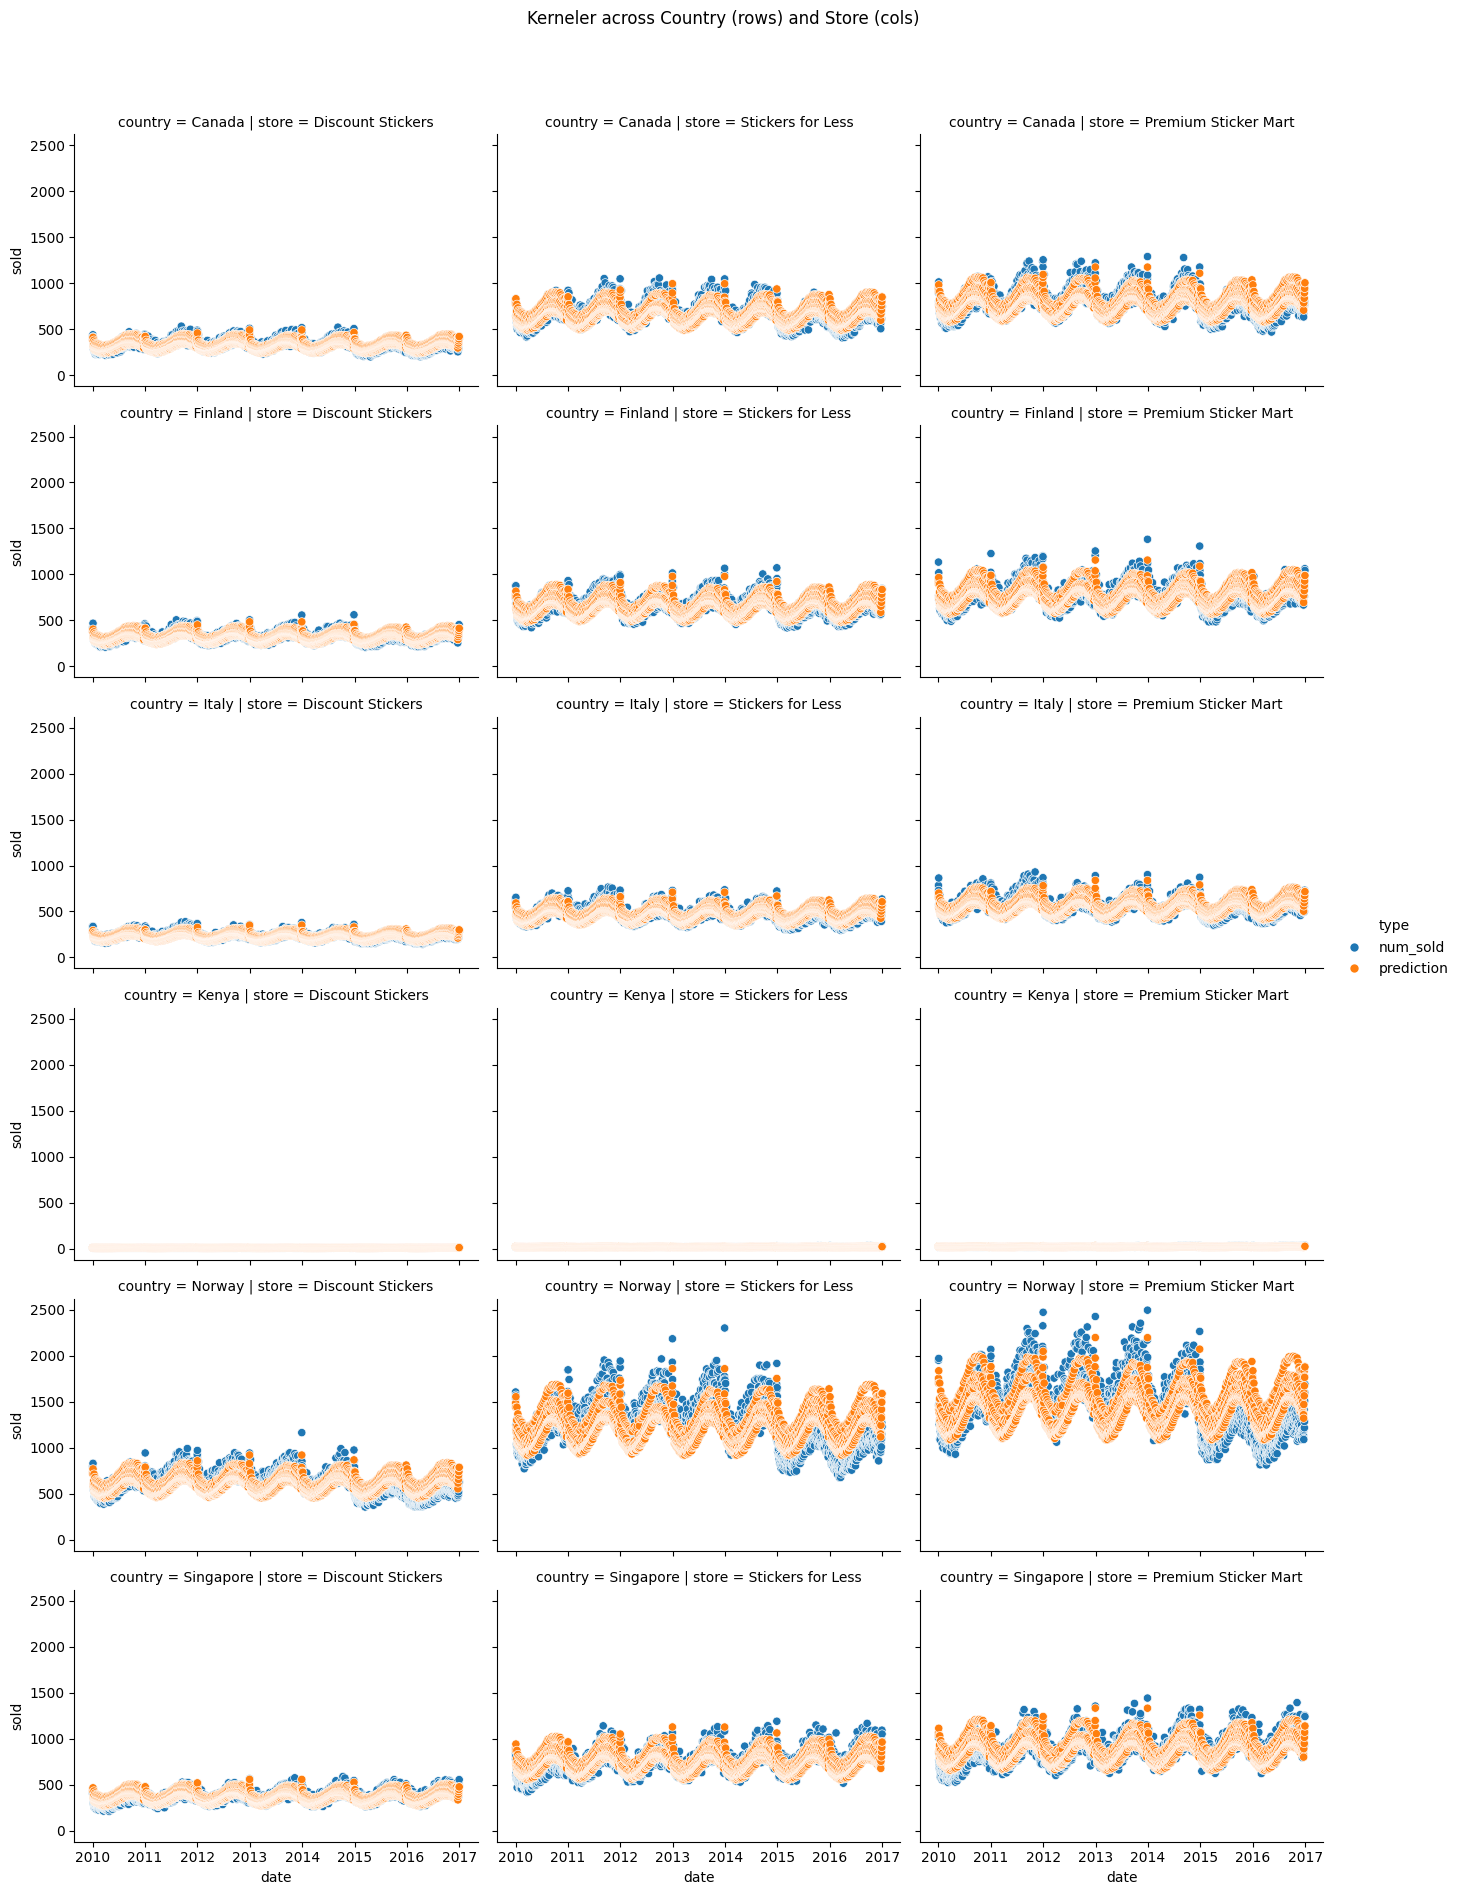

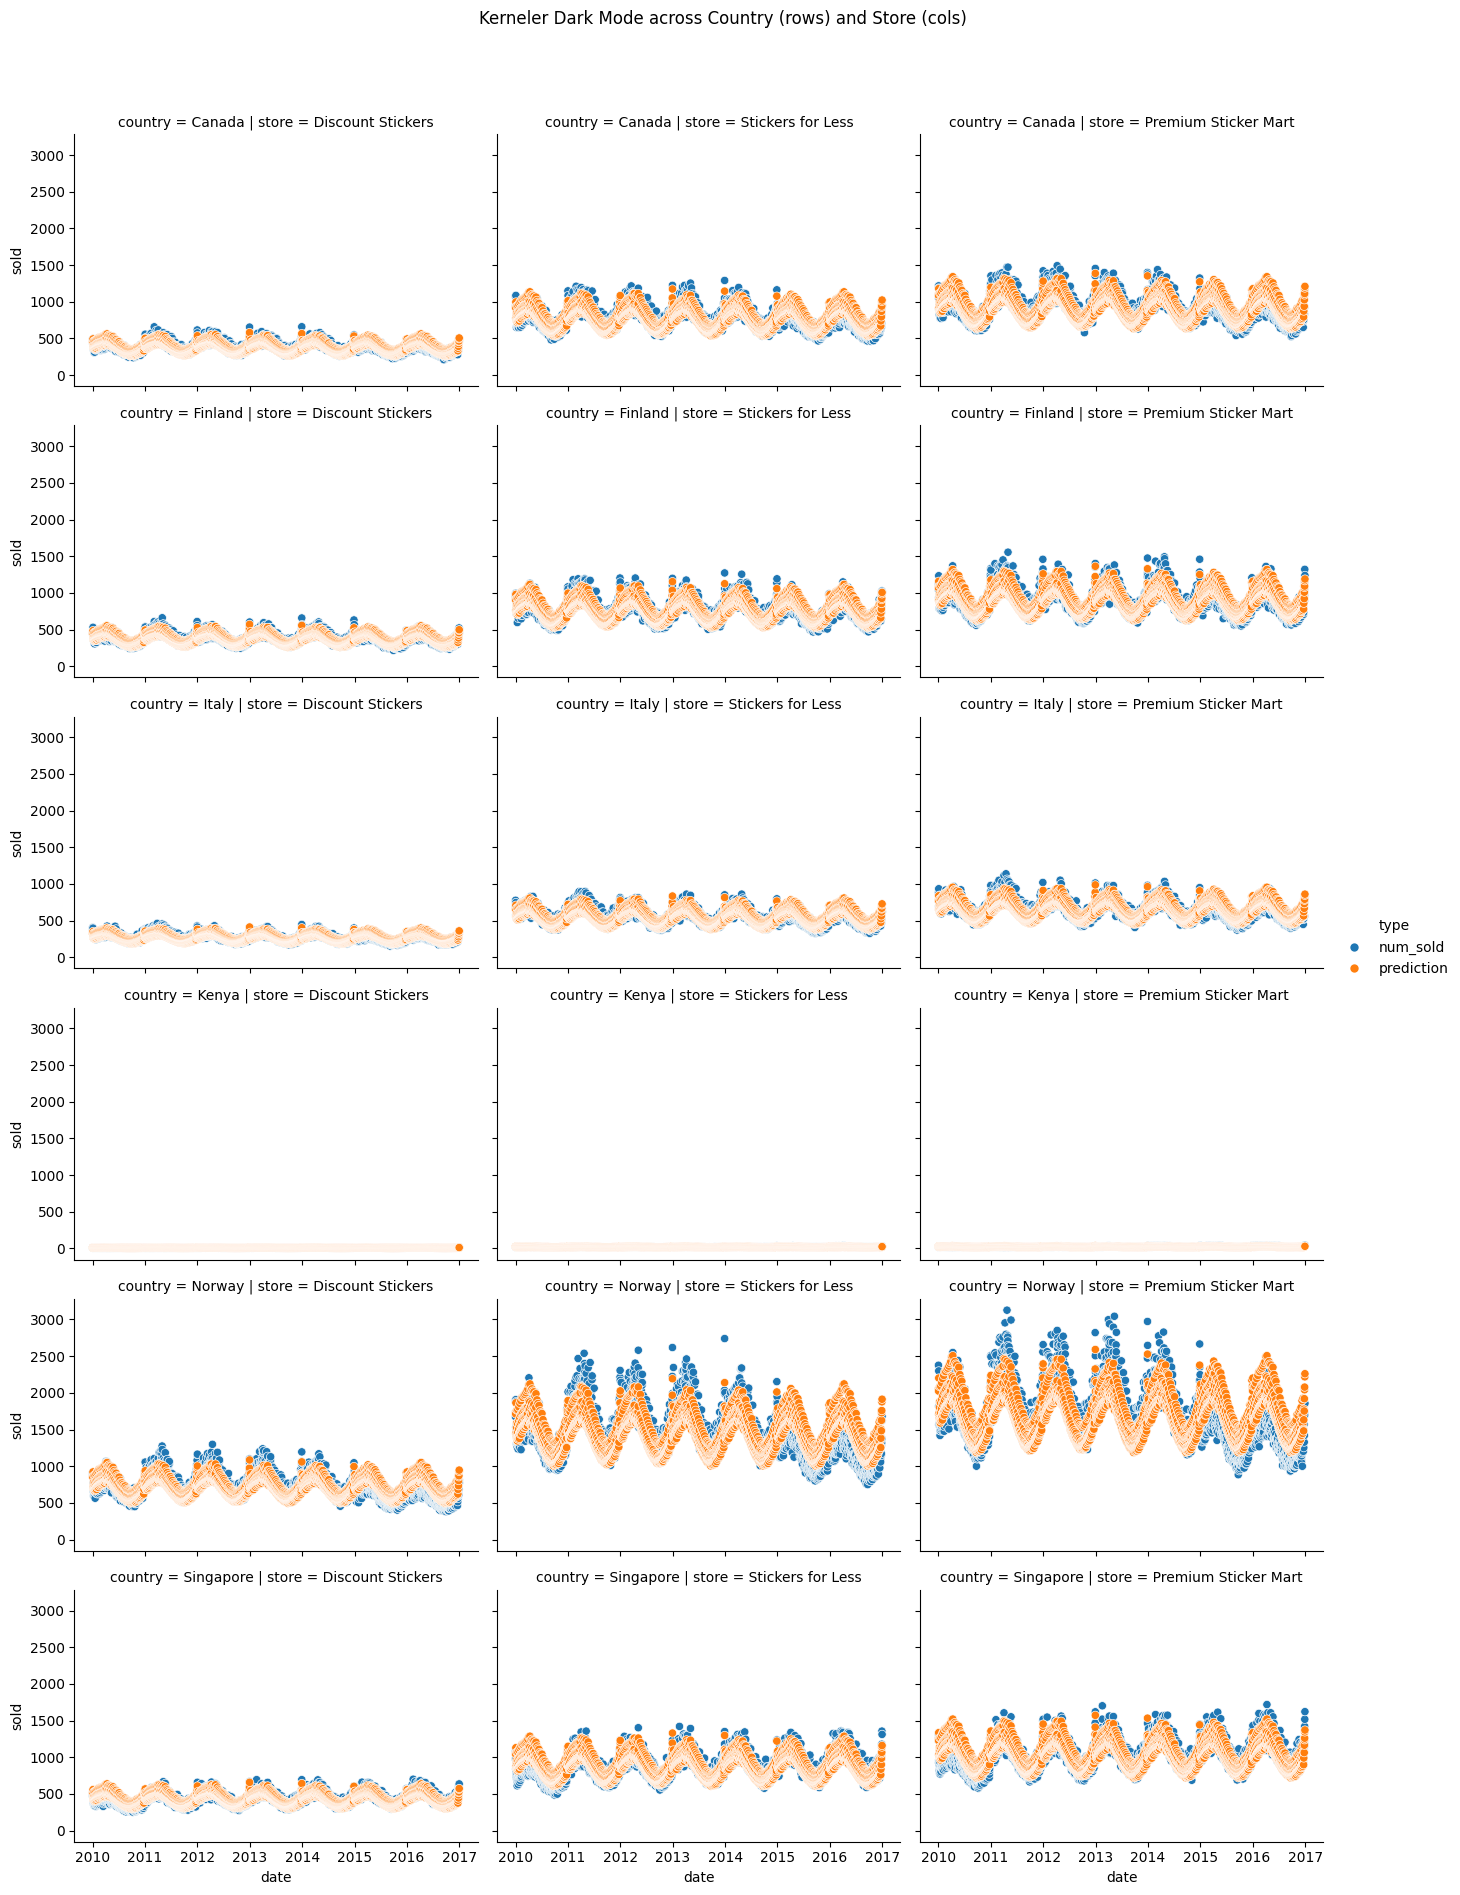

In [7]:
melting = ['num_sold', 'prediction']
melted = train.melt(id_vars=[col for col in train.columns if col not in melting], var_name='type', value_name='sold')

for product in train['product'].unique():
    subset = melted[melted['product'] == product]

    sns.relplot(data=subset, x='date', y='sold', col='store', row='country', kind='scatter', height=3, aspect=1.5, hue='type')
    plt.suptitle(f'{product} across Country (rows) and Store (cols)', y=1.05)
    plt.show()

In [8]:
# Try test rq
test = pd.read_csv(DIRECTORY + 'test.csv', parse_dates=['date'])
test = prep_dataset(test)

test[['id', 'prediction']].rename(columns={'prediction': 'num_sold'}).to_csv('multiplicative_submission.csv', index=False)

KeyError: 'num_sold'